In [1]:
from tqdm import tqdm
import utils
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2,venn2_circles
import functools
import pickle
import pandas as pd
import re
from itertools import combinations, product
from big_o.big_o import (  # noqa
    big_o,
    infer_big_o_class,
)
import os
from utils import stream_jsonl, read_problems, write_jsonl

#### Introduce the function to compare the time complexity of two piece of code.

In [20]:
# define 
complexity={
    'Constant':0,
    'Logarithmic':1e-4,
    'Linear':1,
    'Linearithmic':(1+1e-4),
    'Quadratic':2,
    'Cubic':3,
    'Exponential':6,
}
def get_score(x):
    cplex_x = x.split(':')[0]
    if cplex_x == 'Polynomial':
        # value = x.split('n^')[-1]
        # value = value.split('(')[0]
        # Use regular expression to extract numeric values and optional unit
        matches = re.findall(r'([-+]?\d*\.\d+|\d+)\s*\*\s*x\^([+-]?\d*\.?\d+)?\s*(\([^\)]+\))?', x)

        # Convert the extracted values to floats
        numeric_values = [(float(match[0]), float(match[1])) if match[1] else float(match[0]) for match in matches]
        # print(numeric_values)
        return numeric_values[0][-1]
    else:
        return complexity[cplex_x]

def compare_complexity(x,y):
    score_x = get_score(x)
    score_y = get_score(y)
    if score_x<score_y:
        return -1
    elif score_x>score_y:
        return 1
    else:
        return 0



def winner_test(A,B,K):
    best_a = max(A)
    best_b = max(B)
    if best_a > best_b:
        winner = 'en'
    if best_a < best_b:
        winner = 'zh'
    if best_a == best_b:
        winner = 'both'
    return winner

def correct_p(A,K):
    if max(A) > 0:
        return 1
    else:
        return 0



#### Load data

In [4]:
# laod question set and get task id
TASK_ID=[]
for question in stream_jsonl('./data/testsuite/testsuite.jsonl'):
    task_id = question['task_id']
    if task_id not in TASK_ID:
        TASK_ID.append(task_id)
print('Total task:',len(TASK_ID))

Total task: 52


In [6]:
model_list = ['CodeGeeX','CodeGen2.5','CodeLlama','DeepSeek-Coder','StarCoder','GPT-3.5-Turbo']
temp = 0.2
Data = {}

#### Calculate the complexity based on time pairs, then compare the Effectiveness and Effiency Advantages.

In [15]:

K =20

Perf_res = {}

for model in model_list:
    Data[model] = {}
    Perf_res[model] = {}
    print(f"---------------{model}------------------")
    passed_problems={'en':[],'zh':[]}
    for lang in ['en','zh']:
        passed_problems[lang]={}
        for task_id in TASK_ID:
            passed_problems[lang][task_id]=[]

    correctness_file_dir = f'./data/passed/{model}/'
    prompt_list = []

    for name in os.listdir(correctness_file_dir):
        if 'prompt_CoT3' in name:
            prompt = 'prompt_CoT3'
        else:
            prompt=name.split('_')[0]
        if prompt not in prompt_list:
            prompt_list.append(prompt)
    

    for prompt in prompt_list:  
        Data[model][prompt] = {'t=0.2':{},'t=0.8':{}}
                    
        for temp in ['0.2','0.8']:
            
            try:
                passed_problems={'en':[],'zh':[]}
                for lang in ['en','zh']:
                    passed_problems[lang]={}
                    for task_id in TASK_ID:
                        passed_problems[lang][task_id]=[]

                for lang in ['en','zh']:
                    for ele in stream_jsonl(f'./data/passed/{model}/{prompt}_t{temp}-{lang}_passed.jsonl'):
                        if ele['passed'] == True:
                            passed_problems[lang][ele['task_id']].append(1)
                        else:
                            passed_problems[lang][ele['task_id']].append(0)

                
                '''
                        compare_correctness
                '''
                        
                # correct_winners = []
                correct_en={}
                correct_zh={}
                dist_diff_cor={}
                flag = 0
                flag2 = 0
                for task_id in TASK_ID:
                    correct_en[task_id] = correct_p(passed_problems['en'][task_id],K)
                    correct_zh[task_id] = correct_p(passed_problems['zh'][task_id],K)
                    if correct_en[task_id]!=0 and correct_zh[task_id]!=0:
                        flag+=1
                    elif (correct_en[task_id]+correct_zh[task_id])!=0:
                        flag2+=1

                    dist_diff_cor[task_id] = sum(passed_problems['en'][task_id])-sum(passed_problems['zh'][task_id])
                    
                Data[model][prompt][f't={temp}'] = {
                        'CR_en':sum([correct_en[task_id] for task_id in TASK_ID])/len(TASK_ID),
                        'CR_zh':sum([correct_zh[task_id] for task_id in TASK_ID])/len(TASK_ID),
                        'CR_bi':float(flag/len(TASK_ID)),
                        'CRD':float(flag2/len(TASK_ID))
                }
                
                
                #load the time data, and fit Big0 expressions.
                collect_times={}
                for lang in ['en','zh']:
                    if os.path.exists(f'./data/time/{model}/{prompt}_t{temp}-{lang}_seg50_t6.pickle'):
                        with open(f'./data/time/{model}/{prompt}_t{temp}-{lang}_seg50_t6.pickle', 'rb') as file:
                            records= pickle.load(file)
                    else:
                        print('Not found!')
                        print(f'{model}/{prompt}_t{temp}-{lang}_seg50.pickle')
                    
                    
                    for ele in records:
                        task_id = ele['task_id']
                        completion_id = ele['completion_id']
                        runtime_list = ele['time']
                        if ele['task_id'] not in collect_times:
                            collect_times[ele['task_id']] = {'en':[],'zh':[]}
                        x = []
                        y = []
                        for time_stamp in runtime_list:
                            x.append(time_stamp[0])
                            if time_stamp[1]<0:
                                continue
                            y.append(time_stamp[1])
                        
                        if len(y)<len(x)*0.9:
                        
                            continue

                        arr_x = np.array(x)
                        arr_y = np.array(y)
                        collect_times[ele['task_id']][lang].append([arr_x,arr_y])
                
                bigO = {}
                for task_id in collect_times.keys():
                    max_n = -1
                    bigO[task_id] = {'en':[],'zh':[]}
                    for lang in ['en','zh']:
                        for i in range(len(collect_times[task_id][lang])):
                            max_n = max(max_n, max(collect_times[task_id][lang][i][0]))
                    if max_n>1e4:
                        for lang in ['en','zh']:
                            for i in range(len(collect_times[task_id][lang])):
                                collect_times[task_id][lang][i][0] = collect_times[task_id][lang][i][0]*1e4/max_n

                    # measure big o
                    for lang in ['en','zh']:
                        for i in range(len(collect_times[task_id][lang])):
                            x = collect_times[task_id][lang][i][0]
                            y = collect_times[task_id][lang][i][1]
                            try:
                                results = infer_big_o_class(x, y, verbose=False)
                                bigO[task_id][lang].append(-1*get_score(str(results[0])))
                                if bigO[task_id][lang][-1]==-1 and type(for_show_1_x)==str:
                                    for_show_1_x = x
                                    for_show_1_y = y
                                    for_show_1_r = results
                                if bigO[task_id][lang][-1]==-2 and type(for_show_2_x)==str:
                                    for_show_2_x = x
                                    for_show_2_y = y
                                    for_show_2_r = results
                    
                            except:
                                # print('error',task_id,lang,i)
                                continue
                
                '''
                        compare_performance
                '''
                for task_id in collect_times.keys():
                    for lang in ['en','zh']:
                        if(len(bigO[task_id][lang])<10):
                            for i in range(10-len(bigO[task_id][lang])):
                                bigO[task_id][lang].append(-100)
                

                complex_winners = {}
                for task_id in bigO:
                    if correct_en[task_id]==0 and correct_zh[task_id]==0:
                        continue
                    pk = winner_test(bigO[task_id]['en'],bigO[task_id]['zh'],K)
                    complex_winners[task_id]=pk

                Perf_res[model][temp] = complex_winners

                en_num = 0
                zh_num = 0
                both_num = 0
                for task_id in complex_winners.keys():
                    if complex_winners[task_id]=='en':
                        en_num+=1
                    if complex_winners[task_id]=='zh':
                        zh_num+=1
                    if complex_winners[task_id]=='both':
                        both_num+=1
                
                Data[model][prompt][f't={temp}']['PAR_en'] = en_num/len(complex_winners)
                Data[model][prompt][f't={temp}']['PAR_zh'] = zh_num/len(complex_winners)
                Data[model][prompt][f't={temp}']['PDR'] = (en_num+zh_num)/len(complex_winners)

            except Exception as FileNotFoundError:
                continue

        

---------------CodeGeeX------------------
---------------CodeGen2.5------------------
---------------CodeLlama------------------
---------------DeepSeek-Coder------------------
---------------StarCoder------------------
---------------GPT-3.5-Turbo------------------


#### Save the data

In [23]:
import pickle
with open("./data/analysis/prompting_data.pkl", "wb") as f:
    pickle.dump(Data, f)

In [24]:
Data
# show the data type

{'CodeGeeX': {'BP': {'t=0.2': {'CR_en': 0.5384615384615384,
    'CR_zh': 0.5192307692307693,
    'CR_bi': 0.4807692307692308,
    'CRD': 0.09615384615384616,
    'PAR_en': 0.23333333333333334,
    'PAR_zh': 0.3333333333333333,
    'PDR': 0.5666666666666667},
   't=0.8': {'CR_en': 0.6346153846153846,
    'CR_zh': 0.5576923076923077,
    'CR_bi': 0.5384615384615384,
    'CRD': 0.11538461538461539,
    'PAR_en': 0.17647058823529413,
    'PAR_zh': 0.20588235294117646,
    'PDR': 0.38235294117647056}},
  'DI': {'t=0.2': {'CR_en': 0.5961538461538461,
    'CR_zh': 0.5384615384615384,
    'CR_bi': 0.5384615384615384,
    'CRD': 0.057692307692307696,
    'PAR_en': 0.16666666666666666,
    'PAR_zh': 0.16666666666666666,
    'PDR': 0.3333333333333333},
   't=0.8': {'CR_en': 0.6153846153846154,
    'CR_zh': 0.6346153846153846,
    'CR_bi': 0.5769230769230769,
    'CRD': 0.09615384615384616,
    'PAR_en': 0.34285714285714286,
    'PAR_zh': 0.2,
    'PDR': 0.5428571428571428}},
  'CoT': {'t=0.2': {'

### Here, we analyze the impact of different prompting on the results through visualization (RQ3).
(Note: We subsequently supplemented experiments on GPT-3.5.)

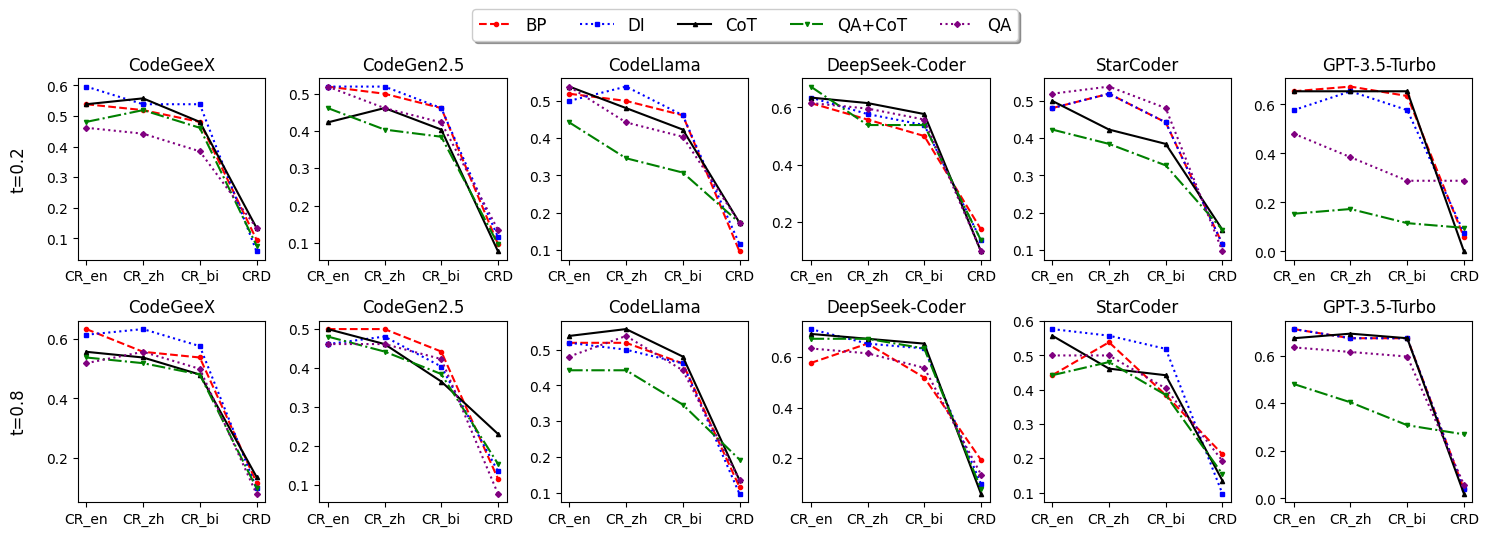

In [25]:
import matplotlib.pyplot as plt

line_styles = [ '--', ':', '-','-.', 'dotted']
colors = [ 'red', 'blue', 'black','green', 'purple']
markers = ['o', 's', '^', 'v', 'D']

fig, axs = plt.subplots(2, 6, figsize=(15, 5))  # 2 rows, 5 columns

for col, temp in enumerate(['0.2', '0.8']):
    for row, model in enumerate(Data.keys()):
        # X = ['CR_en', 'CR_zh', 'CR_bi', 'CRD', 'PAR_en', 'PAR_zh', 'PDR']
        X = ['CR_en', 'CR_zh', 'CR_bi', 'CRD']
        Y = {}
        idx = 0
        for prompt in Data[model].keys():
            Y[prompt] = []
            try:
                for x in X:
                    Y[prompt].append(Data[model][prompt][f't={temp}'][x])
            except:
                pass
            if len(Y[prompt]) > 0:
                axs[col, row].plot(X, Y[prompt], label=prompt, linestyle=line_styles[idx], color=colors[idx], marker=markers[idx],markersize=3)
            idx += 1
        # axs[col, row].legend()
        axs[col, row].set_title(model)

# Add a single legend for the entire plot
handles, labels = axs[0, 0].get_legend_handles_labels()
large_font = {'size': 'larger'}
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=5, fancybox=True, shadow=True, prop=large_font) 

# Add text annotations for t=0.2 and t=0.8 next to the subplots
for ax, temp in zip(axs[:, 0], ['t=0.2', 't=0.8']):
    ax.annotate(temp, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=12, rotation=90)
plt.tight_layout()
plt.savefig(f'./data/analysis/prompting_effectiveness.pdf', dpi=300, bbox_inches='tight')
plt.show()


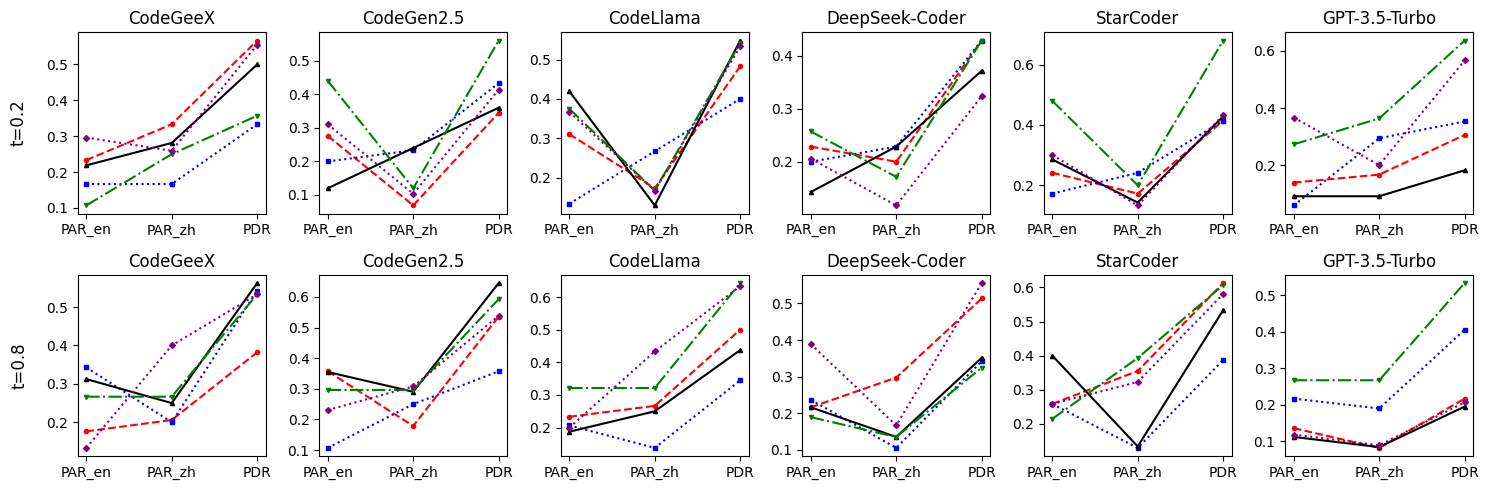

In [27]:
import matplotlib.pyplot as plt

line_styles = [ '--', ':', '-','-.', 'dotted']
colors = [ 'red', 'blue', 'black','green', 'purple']
markers = ['o', 's', '^', 'v', 'D']

fig, axs = plt.subplots(2, 6, figsize=(15, 5))  # 2 rows, 5 columns

for col, temp in enumerate(['0.2', '0.8']):
    for row, model in enumerate(Data.keys()):
        # X = ['CR_en', 'CR_zh', 'CR_bi', 'CRD', 'PAR_en', 'PAR_zh', 'PDR']
        X = ['PAR_en', 'PAR_zh', 'PDR']
        Y = {}
        idx = 0
        for prompt in Data[model].keys():
            Y[prompt] = []
            try:
                for x in X:
                    Y[prompt].append(Data[model][prompt][f't={temp}'][x])
            except:
                pass
            if len(Y[prompt]) > 0:
                axs[col, row].plot(X, Y[prompt], label=prompt, linestyle=line_styles[idx], color=colors[idx], marker=markers[idx],markersize=3)
            idx += 1
        # axs[col, row].legend()
        axs[col, row].set_title(model)

# # Add a single legend for the entire plot
# handles, labels = axs[0, 0].get_legend_handles_labels()
# large_font = {'size': 'larger'}
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=5, fancybox=True, shadow=True, prop=large_font) 

# Add text annotations for t=0.2 and t=0.8 next to the subplots
for ax, temp in zip(axs[:, 0], ['t=0.2', 't=0.8']):
    ax.annotate(temp, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=12, rotation=90)
plt.tight_layout()
plt.savefig(f'./data/analysis/prompting_efficiency.pdf', dpi=300, bbox_inches='tight')
plt.show()